In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

# Loading the csv files

In [2]:
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

# Data Cleaning

In [3]:
print(df_train.shape)
df_train.head()

(16000, 2)


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
print(df_val.shape)
df_val.head()

(2000, 2)


,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [5]:
print(df_test.shape)
df_test.head()

(2000, 2)


,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [6]:
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [7]:
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [8]:
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [9]:
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

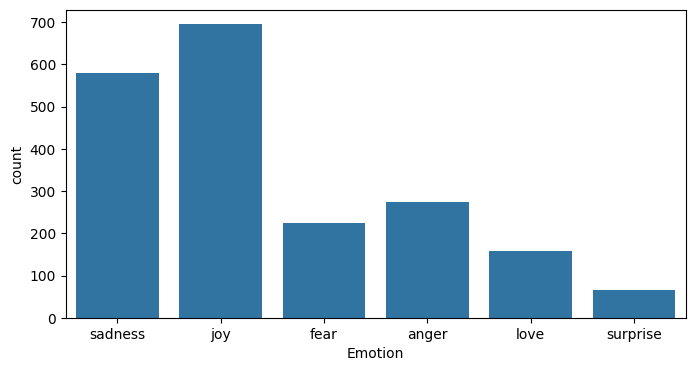

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

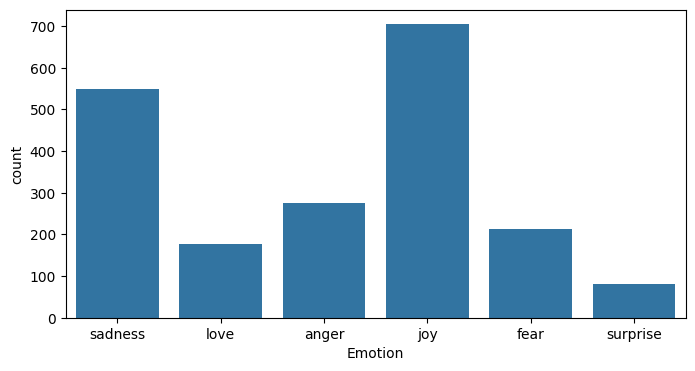

In [11]:
df_val.Emotion.value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

# Cleaning text

In [12]:
def clean_text(Text):
    
    text = re.sub(r'https?://\S+|www\.\S+', '', Text)     # Remove URLs and any trailing spaces after them
    text = re.sub(r'[^a-zA-Z\s]', '', text)               # Remove non-alphabetic characters except spaces
    text = text.lower()                                   # Convert text to lowercase
    text = re.sub(r'\s+', ' ', text).strip()              
    return text

In [15]:
df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)
df_val['Text'] = df_val['Text'].apply(clean_text)

# Preprocessing text

In [16]:
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [17]:
# Reshaping Labels to 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Encoding target column using OHE

In [18]:
encoder = OneHotEncoder(sparse_output=False)

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)

# Tokenization

In [19]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences

In [20]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

# Padding (make all sequences the same length)

In [21]:
max_length = 20  

X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')


# Define the model

In [22]:
model = Sequential()
model.add(Input(shape=(20,)))
model.add(Embedding(10000, 200, trainable=False))
model.add(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 200)             │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 20, 256)             │         467,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,797,446 (10.67 MB)

 Trainable params: 797,446 (3.04 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

# Compile the model

In [23]:
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model on the training dataset

In [24]:
history = model.fit(X_train, y_train, 
                    epochs=25,
                    verbose=1,
                    batch_size=256, 
                    validation_data=(X_val,y_val))

Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.3362 - loss: 1.5939 - val_accuracy: 0.3720 - val_loss: 1.5760
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 989ms/step - accuracy: 0.3589 - loss: 1.5666 - val_accuracy: 0.3685 - val_loss: 1.5642
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3616 - loss: 1.5605 - val_accuracy: 0.3900 - val_loss: 1.5523
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 987ms/step - accuracy: 0.3808 - loss: 1.5386 - val_accuracy: 0.3830 - val_loss: 1.5471
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 862ms/step - accuracy: 0.3896 - loss: 1.5245 - val_accuracy: 0.4135 - val_loss: 1.4748
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 950ms/step - accuracy: 0.4070 - loss: 1.4937 - val_accuracy: 0.4210 - val_loss: 1.4729
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 969ms/step - accuracy: 0.4347 - loss: 1.4385 - val_accuracy: 0.4835 - val_loss: 1.3566
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 956ms/step - accuracy: 0.4752 - loss: 1.3544 - val_accuracy: 

# Testing the model on the testing dataset

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8395 - loss: 0.3858
Test Accuracy: 0.8395
Test Loss: 0.3858


#  Model Performance Visualization

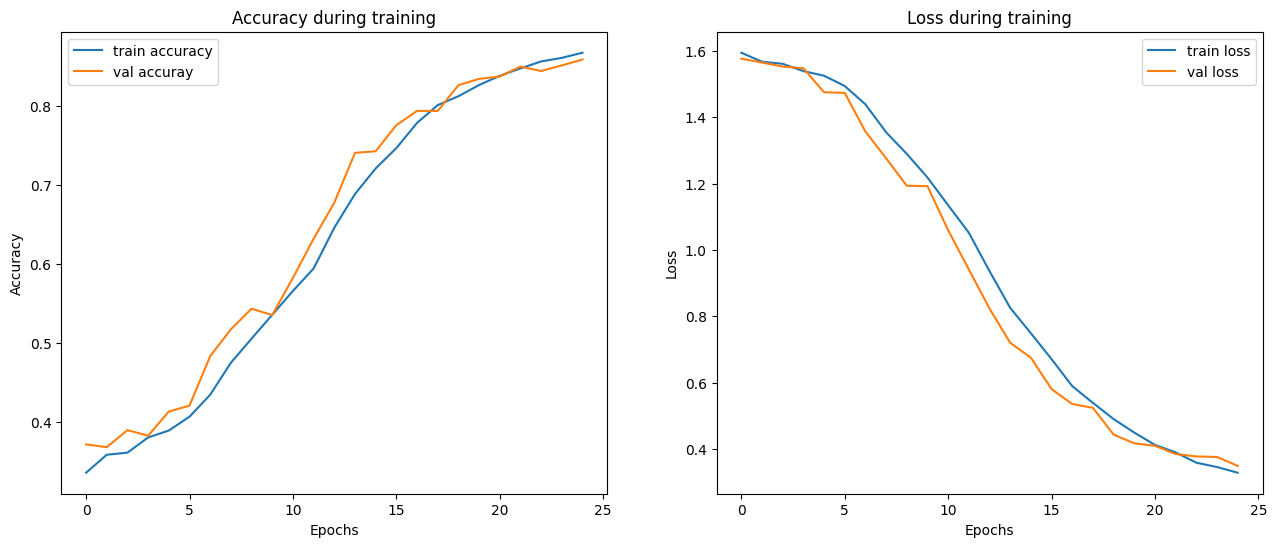

In [26]:
plt.figure(figsize=(15.5, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuray')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()